In [1]:
import scanpy as sc
import squidpy as sq
import os
import anndata as ad
import tqdm
import itertools as it
import pandas as pd

/Users/hannah.spitzer/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/napari/__init__.py:44: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.7. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [2]:
# get spatial dataset including hires tissue image
img = sq.im.ImageContainer(os.path.expanduser("~/.cache/squidpy/tutorial_data/visium_hne.tiff"))
adata = sc.read(os.path.expanduser("~/.cache/squidpy/tutorial_data/visium_hne.h5ad"))


/Users/hannah.spitzer/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Prepare the image for feature extraction by calculating a segmentation image (cf segmentation example)

In [3]:
# convert to grayscale
sq.im.process_img(img, img_id="image", processing="gray")
# smooth image
sq.im.process_img(img, img_id="image_gray", processing="smooth", sigma=4)
# segment
sq.im.segment_img(img=img, img_id="image_gray_smooth", model_group="watershed", thresh=0.28, geq=False)

We will now extract features from the img at each visium spot to create a `obs x features` matrix in `adata.obsm`. 

By extracting image features we are aiming to get both similar and complementary information to the gene expression values. 
Similar information is for example present in the case of a tissue with two different cell types whose morphology is different. Such cell type information is then contained in both the gene expression values and the tissue image features.
Complementary or additional information is present in the fact that we can use a nucleous segmentation to count cells and add features summarising the immediate spatial neighborhood of a spot. 

We provide several different feature extractors and a flexible pipeline of extracting features of different scales and sizes.
There are several detailled examples of how to use `calculate_image_featutes` TODO ref to examples.

Here, we will extract `summary`, `histogram`, `segmentation`, and `texture` features.
To provide more context and allow the calculation of multi-scale features, we will additionally calculate `summary` and `histogram` features at different crop sizes and scales.



In [4]:
# define different feature calculation combinations
params = {
    # all features, corresponding only to tissue underneath spot
    'features_orig': 
    {'features': ['summary', 'texture', 'histogram', 'segmentation'],
    'size': 1,
    'scale': 1.0,
    'mask_circle': True},
    # summary and histogram features with a bit more context, original resolution
    'features_context': 
    {'features': ['summary', 'histogram'],
    'size': 2,
    'scale': 1.0},
    # summary and histogram features with more context and at lower resolution
    'features_lowres' :
    {'features': ['summary', 'histogram'],
    'size': 4,
    'scale': 0.25}
}
# define image layer to use for segmentation
features_kwargs = {'segmentation': {'label_img_id': 'segmented_watershed'}}

In [5]:
# extract features with the different parameters in a loop
for feature_name, cur_params in tqdm.tqdm(params.items()):
    # features will be saved in `adata.obsm[feature_name]`
    sq.im.calculate_image_features(adata, img, key_added=feature_name, n_jobs=4, features_kwargs=features_kwargs, **cur_params)

100%|██████████| 3/3 [02:30<00:00, 50.25s/it]


In [6]:
# fill nans
adata.obsm['features_orig'].fillna(value=0, inplace=True)
# combine features in one dataframe
adata.obsm['features'] = pd.concat([adata.obsm[f] for f in params.keys()], axis='columns')
# make sure that we have no duplicated feature names in the combined table
adata.obsm['features'].columns = ad.utils.make_index_unique(adata.obsm['features'].columns)

We can use the extracted features to calculate a feature-space clustering. 
This provides a good visual representation of the information contained in the image features.
Let us compare the clustering for `summary`, `histogram`, `segmentation`, and `texture` features.

In [7]:
# helper function returning a clustering
def cluster_features(features, like=None):
    """Calculate leiden clustering of features.
    
    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    #adata.var_names_make_unique()
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1]-1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)
    
    return adata.obs['leiden']

In [10]:
#adata.obs['features_cluster_noscale'] = cluster_features(adata.obsm['features'])
#sc.pl.spatial(adata, color=['features_cluster', 'features_cluster_noscale'])

In [11]:
# cluster features using different subsets
adata.obs['features_summary_cluster'] = cluster_features(adata.obsm['features'], like='summary')
adata.obs['features_histogram_cluster'] = cluster_features(adata.obsm['features'], like='histogram')
adata.obs['features_texture_cluster'] = cluster_features(adata.obsm['features'], like='texture')
adata.obs['features_segmentation_cluster'] = cluster_features(adata.obsm['features'], like='segmentation')
adata.obs['features_cluster'] = cluster_features(adata.obsm['features'])

/Users/hannah.spitzer/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/Users/hannah.spitzer/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


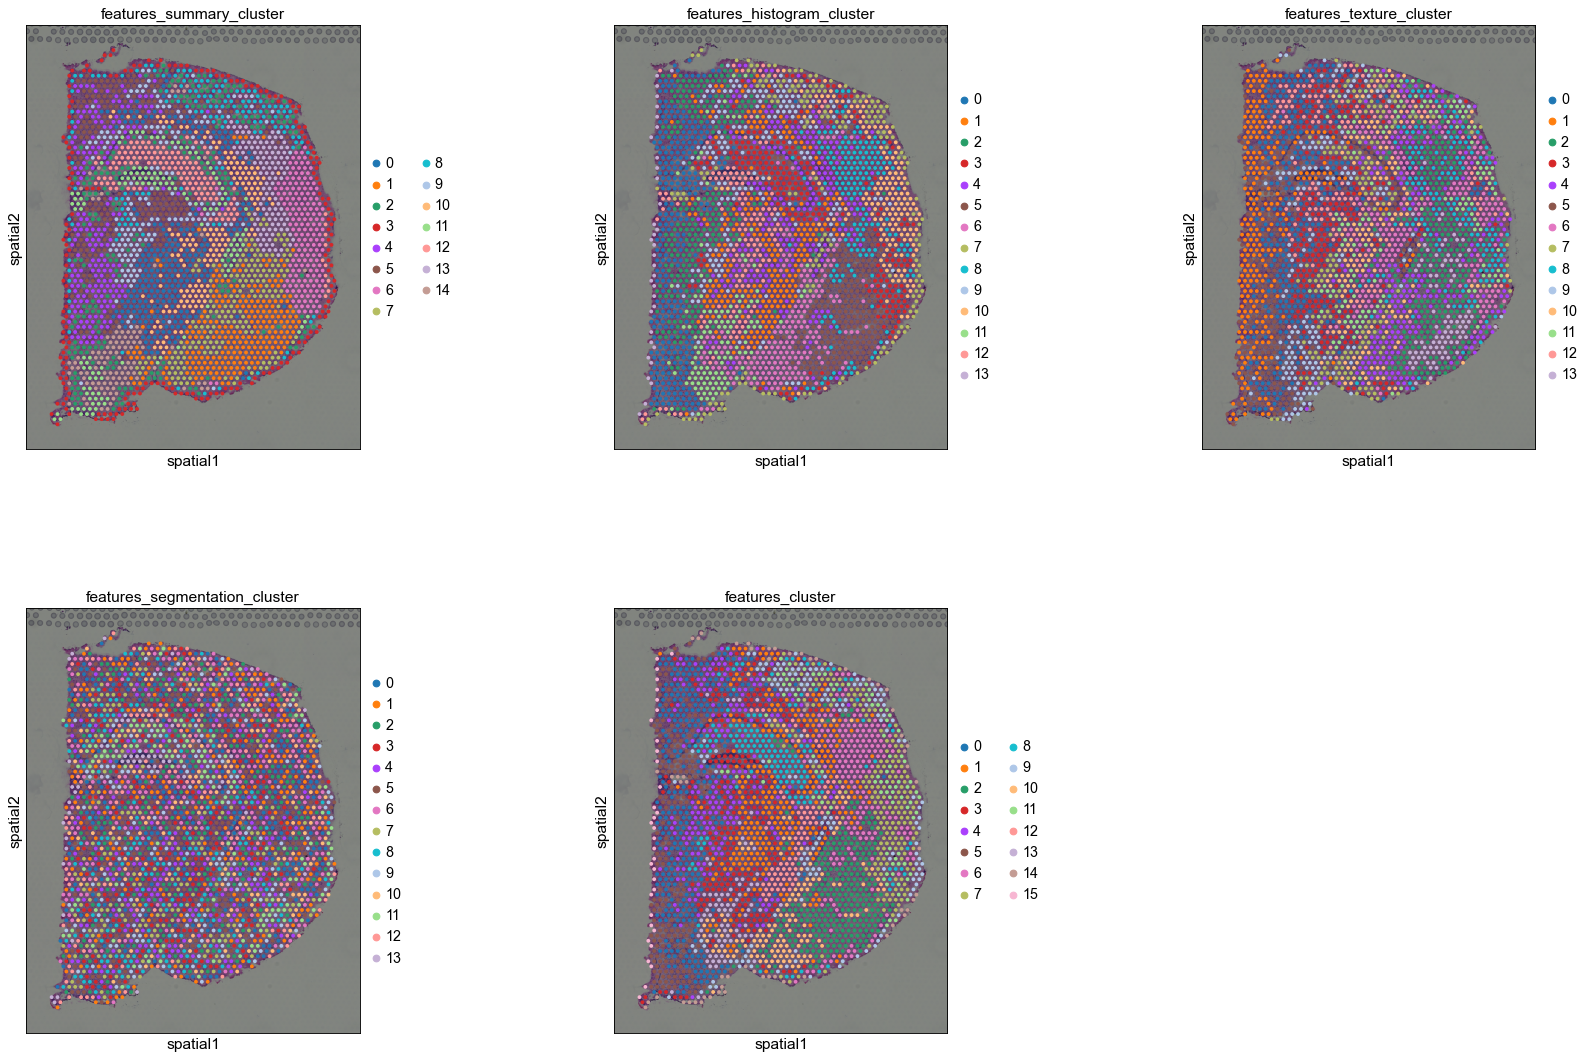

In [13]:
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.pl.spatial(adata, color=['features_summary_cluster', 'features_histogram_cluster', 'features_texture_cluster', 'features_segmentation_cluster',
                           'features_cluster'], ncols=3)

We can see above that the feature clusters of the different features are quite diverse, but all of them reflect the structure of the hippocampus by assigning different clusters to the different structural areas.
The segmentation features provide the most diverse clustering, as they only represent number and size of cells in each visium spot. 

In fact, the number of cells alone provides an interesting view of the data, showing that surrouning the dark gray band of the hippocampus containing pyramidial cells (cluster "Pyramidial Layer" and "Pyramidial layer Dentate Gyrus" in the gene-space clustering), is an area of lower cell-density (cluster "Hippocampus" in the gene-space clustering):


In [25]:
adata.obsm['features'].filter(like='segmentation')

segmentation_label  segmentation_area_mean  \
AAACAAGTATCTCCCA-1                   5               95.400000   
AAACAATCTACTAGCA-1                  10              131.300000   
AAACACCAATAACTGC-1                   2               43.500000   
AAACAGAGCGACTCCT-1                   2               29.000000   
AAACCGGGTAGGTACC-1                   5               29.000000   
...                                ...                     ...   
TTGTTGTGTGTCAAGA-1                  17              114.176471   
TTGTTTCACATCCAGG-1                  13               45.615385   
TTGTTTCATTAGTCTA-1                   8               53.250000   
TTGTTTCCATACAACT-1                   5               51.000000   
TTGTTTGTGTAAATTC-1                   5               22.400000   

                    segmentation_mean_intensity_ch0_mean  \
AAACAAGTATCTCCCA-1                             67.899566   
AAACAATCTACTAGCA-1                             86.354694   
AAACACCAATAACTGC-1                             47.921371   
AAACAGAGCGACTCCT-1                             73.935185   
AAACCGGGTAGGTACC-1                             64.720405   
...                                                  ...   
TTGTTGTGTGTCAAGA-1                             60.459031   
TTGTTTCACATCCAGG-1                             52.113848   
TTGTTTCATTAGTCTA-1                             56.484785   
TTGTTTCCATACAACT-1                             60.609774   
TTGTTTGTGTAAATTC-1                             61.548247   

                    segmentation_mean_intensity_ch1_mean  \
AAACAAGTATCTCCCA-1                             49.167967   
AAACAATCTACTAGCA-1                             45.704727   
AAACACCAATAACTGC-1                             41.673675   
AAACAGAGCGACTCCT-1                             44.000000   
AAACCGGGTAGGTACC-1                             46.371964   
...                                                  ...   
TTGTTGTGTGTCAAGA-1                             44.726686   
TTGTTTCACATCCAGG-1                             43.385630   
TTGTTTCATTAGTCTA-1                             45.092058   
TTGTTTCCATACAACT-1                             41.520956   
TTGTTTGTGTAAATTC-1                             47.369435   

                    segmentation_mean_intensity_ch2_mean  
AAACAAGTATCTCCCA-1                             92.986757  
AAACAATCTACTAGCA-1                             88.703229  
AAACACCAATAACTGC-1                             72.033122  
AAACAGAGCGACTCCT-1                             85.055556  
AAACCGGGTAGGTACC-1                             90.411577  
...                                                  ...  
TTGTTGTGTGTCAAGA-1                             86.228135  
TTGTTTCACATCCAGG-1                             79.886279  
TTGTTTCATTAGTCTA-1                             83.360124  
TTGTTTCCATACAACT-1                             80.084696  
TTGTTTGTGTAAATTC-1                             84.317977  

[2688 rows x 5 columns]

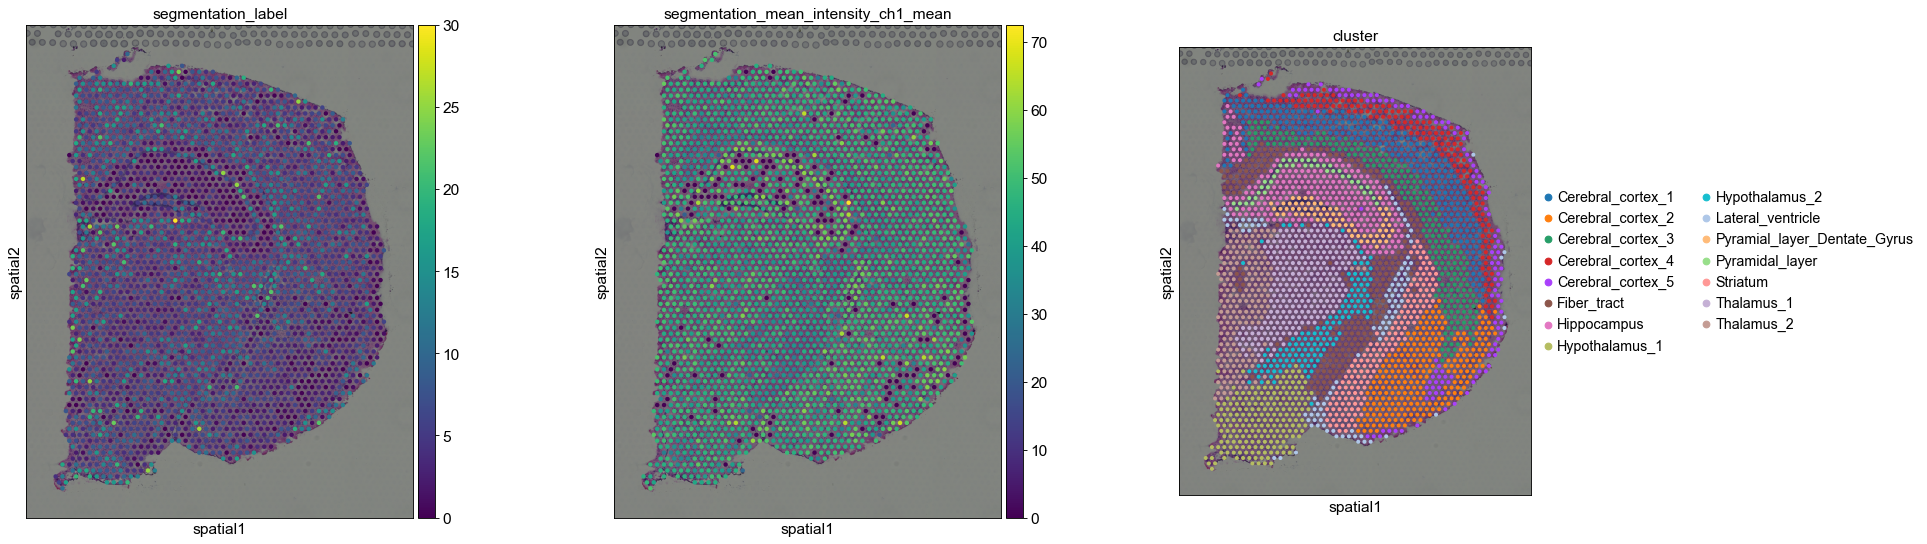

In [26]:
# compare number of cells extracted from segmentation with gene-space clustering
sc.pl.spatial(sq.pl.extract(adata, 'features'), color=['segmentation_label', 'segmentation_mean_intensity_ch1_mean', 'cluster'])

Image feature information like this can enhance the characterisation of gene-space clusters.

Finally, a combined feature-space clustering using all features can be calculated and compared to a previouly calculated gene-space clustering. 
This allows us to assess shared information between tissue image and gene expression counts, and novel information provided by either modalities.

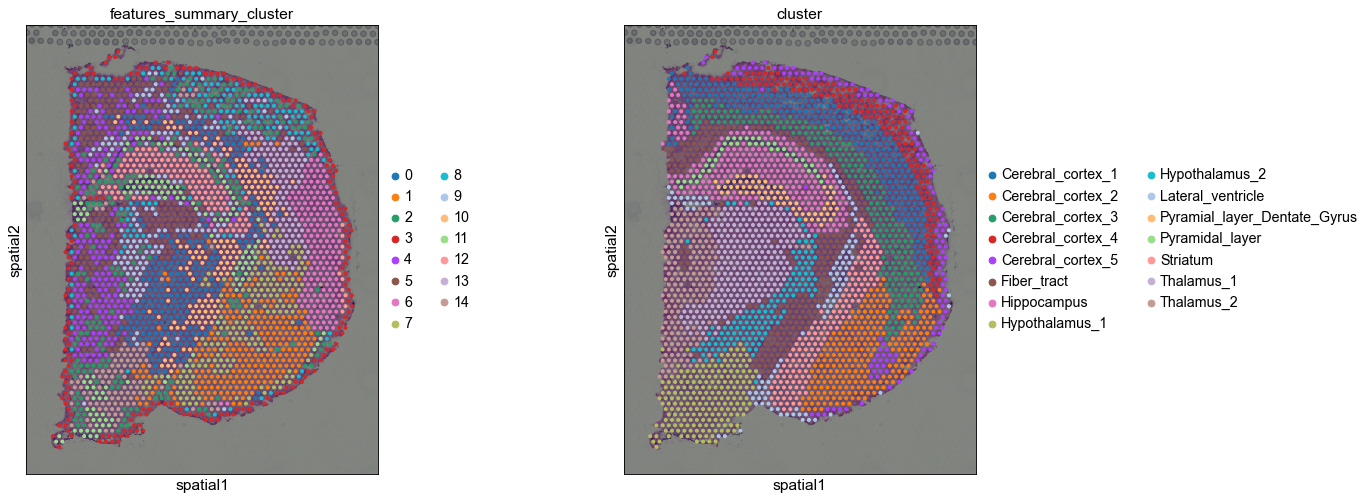

In [27]:
# compare feature clustering with gene clustering
sc.pl.spatial(adata, color=['features_summary_cluster', 'cluster'])

This is only a simple analysis of the image features, note that you could also use the image features to e.g. compute a common image and gene representation using e.g. an VAE (TODO: maybe some citations here).

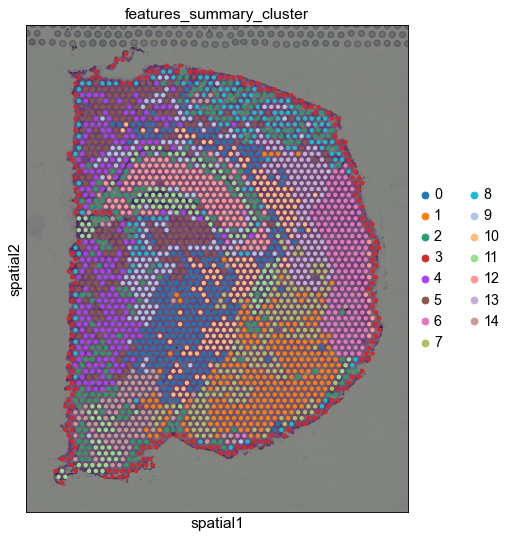

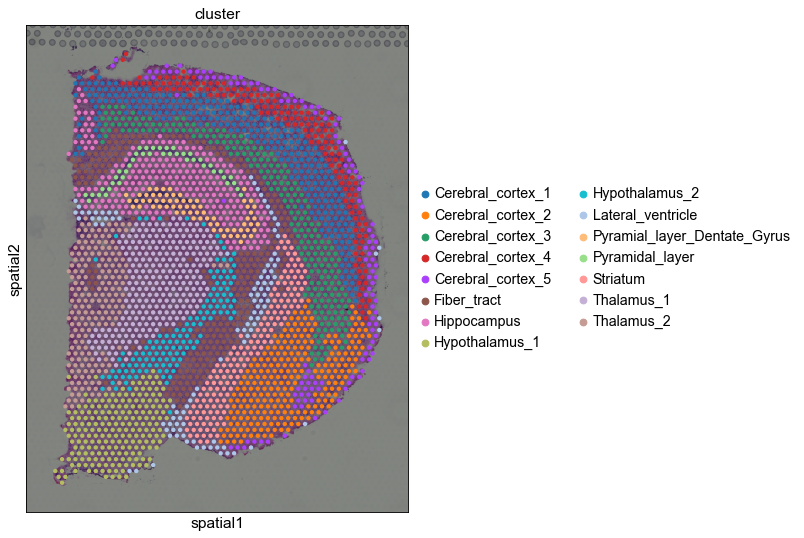

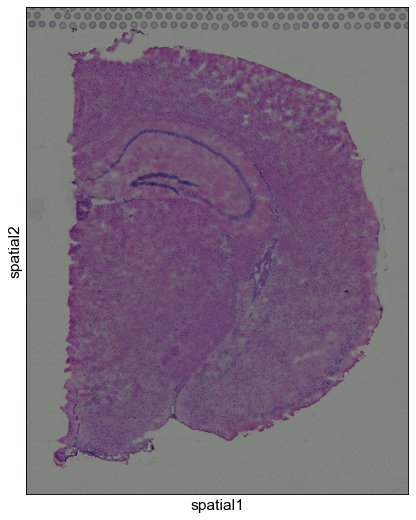

In [33]:
# save images
sc.pl.spatial(adata, color=['features_summary_cluster'], save='hne_features_summary_cluster.png')
sc.pl.spatial(adata, color=['cluster'], save='hne_cluster.png')
sc.pl.spatial(adata, save='hne.png')

We provide several different feature extractors and a flexible pipeline of extracting features of different scales and sizes. How should you choose which features to extract and which hyper-parameters to use? 
Unfortunately this is a very complex question that can only be answered on a case-to-case basis, considering the concrete data and aims of the analysis. 
In general, we remommend the following steps:
1. understand the different available options for extracting features (ref to notebooks)
2. exemplarily extract features from your data and observe qualitative differences that different hyperparameters make (ref to notebooks)
3. to quantitalively evaluate different hyperparameter options, you could define a measure of goodness for a feature-space clustering and optimise this measure using a grid search. Below, we will show an example of this.

An easy measure to evaluate a feature-space clustering is the silhouette score TODO function.
A silhouette score denotes how coherent a cluster is and how different other clusters are. 
Silhouette scores as usually used to assess how well clustered data is, with higher silhouette scores denoting more clustered data. Here, we use the spatial distance between points as x which results in the slihouette score measureing spatiall compact clusters.
We might desire spatially coherent clusters when we are aimimg to extract features that represent different cell types and cell types in the tissue are spatially distributed. 
Note that in your specific example you might want to optimise hyper-parameters for another clustering metric.

Here, we will use the silhouette score to choose a combination of feature extractors and crop sizes and scales. We will use default `features_kwargs` for each feature extractor

In [ ]:
# TODO: no silhouette score, cluster at size 1,2,4 with scale 1,2,4. (larger scales=no segmentation)
# Extract summary, histogram and segmentation features
# Show resulting clusters at different sizes and scales

# compare with gene-space clustering, say sth about clusters being consistent etc
# calculate this for fluo data as well?

# TODO louis: what is the matter with texture features??

In [27]:
# define variable hyper-parameters to use when extracting features
hyperparams = {
    'features': ['summary', 'texture', 'histogram', 'segmentation'],
    'size': [1,2,4],
    'scale': [1.0, 2.0, 4.0],
}
# define image layer to use for segmentation
features_kwargs = {'segmentation': {'label_img_id': 'segmented_watershed'}}


# get parameters for all combinations of defined hyper-parameters
keys, values = zip(*hyperparams.items())
combinations = []
for bundle in it.product(*values):
    cur_params = dict(zip(keys, bundle))
    cur_params['features_kwargs'] = features_kwargs
    combinations.append(cur_params)
    
print(f'testing {len(combinations)} different parameters for feature extraction')

testing 36 parameters for feature extraction


Now we are ready to calculate features for all combinations of hyper-parameters. 
This runs for about 30mins, which is why you can also load the calculated features from disk.

In [91]:
## COMMENT THIS IN TO EXTRACT THE FEATURES
## extract features with the different combinations in a loop
#for combination in tqdm.tqdm(combinations):
#    feature_name = f'{combination["features"]}_size{combination["size"]}_scale{combination["scale"]}'
#    sq.im.calculate_image_features(adata, img, key_added=feature_name, n_jobs=4, **combination)
#    
## save calculate features to disk
#for key in adata.obsm.keys():
#    pd.DataFrame(adata.obsm[key]).to_csv(f'{key}.csv')

In [94]:
# load previously saved features
feature_names = []
for combination in tqdm.tqdm(combinations):
    feature_name = f'{combination["features"]}_size{combination["size"]}_scale{combination["scale"]}'
    feature_names.append(feature_name)
    adata.obsm[feature_name] = pd.read_csv(f'{feature_name}.csv', index_col=0)

100%|██████████| 36/36 [00:00<00:00, 147.89it/s]


To calculate silhouette scores for different combinations of features, we define two helper functins, `cluster_features` to cluster a list of feature matrices, and `silhouette_score` to directly calculate a silhouette score of a clustering from a list of feature matrices. 

In [162]:
def cluster_features(features, return_pca=False, n_comps=10):
    """Calculate leiden clustering of features."""
    features = pd.concat(features
                         , axis='columns')
    features.fillna(value=0, inplace=True)
    adata = ad.AnnData(features)
    adata.var_names_make_unique()
    sc.pp.scale(adata)
    sc.pp.pca(adata, n_comps=min(n_comps, features.shape[1]-1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)
    
    if return_pca:
        return adata.obs['leiden'], adata.obsm['X_pca']
    return adata.obs['leiden']

def silhouette_score(features):
    """Calculate silhouette score of clustering."""
    import sklearn
    leiden, X_pca = cluster_features(features, return_pca=True)
    score = sklearn.metrics.silhouette_score(X_pca, leiden)
    return score


We now use these functions to calculate silhouette scores the calculated features.
For the features with the top 5 silhouette scores, we will also calculate combinations to see if a combination of features performs even better.

In [103]:
# iterate over calculated features and calculate silhouette score of clustering
scores = {}
for f in tqdm.tqdm(feature_names):
    scores[f] = silhouette_score([adata.obsm[f]])

# sort feature_names by their scores
sorted_f = [x for _,x in sorted(zip(scores.values(),scores.keys()), reverse=True)]


# repeat this process for combinations of features
#for i,f1 in tqdm.tqdm(enumerate(feature_names)):
#    for f2 in feature_names[i+1:]:
#        X_pca, clusters = cluster_features([adata.obsm[f1], adata.obsm[f2]])
#        silhouette_scores[f'{f1}-{f2}'] = sklearn.metrics.silhouette_score(X_pca, clusters)


#sklearn.metrics.silhouette_score(adata.obsm['spatial'], ada)

 72%|███████▏  | 26/36 [00:02<00:01,  9.86it/s]/Users/hannah.spitzer/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
 78%|███████▊  | 28/36 [00:02<00:00, 10.03it/s]/Users/hannah.spitzer/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/Users/hannah.spitzer/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
 83%|████████▎ | 30/36 [00:02<00:00, 10.24it/s]/Users/hannah.spitzer/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float6

let us calculate features at different size and scales (when it makes sense).
Here, we will calculate histogram and summary features at sizes 1,2, and 4 and scales 1,2, and 4, and segmentation features at size 1

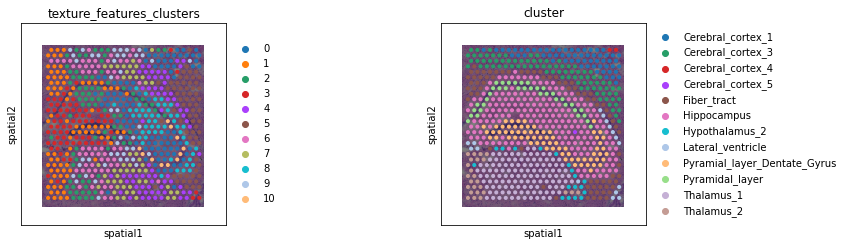

In [170]:
# onlt texture features
adata.obs['texture_features_clusters'] = cluster_features(
    [adata.obsm['texture_size1_scale1.0']])

sc.pl.spatial(adata, color=['texture_features_clusters', 'cluster'])

/Users/hannah.spitzer/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


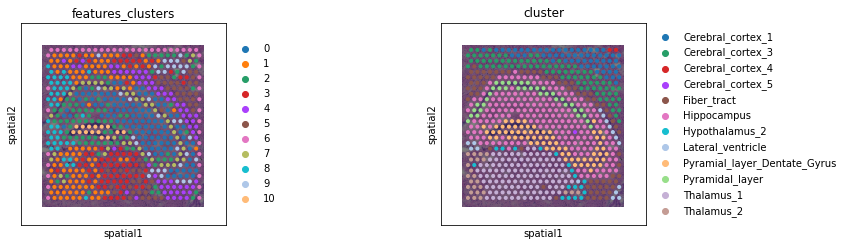

In [173]:
# all features features
adata.obs['features_clusters'] = cluster_features(
    [adata.obsm[f] for f in feature_names if ('texture' not in f)])
sc.pl.spatial(adata, color=['features_clusters', 'cluster'])



Variable names are not unique. To make them unique, call `.var_names_make_unique`.


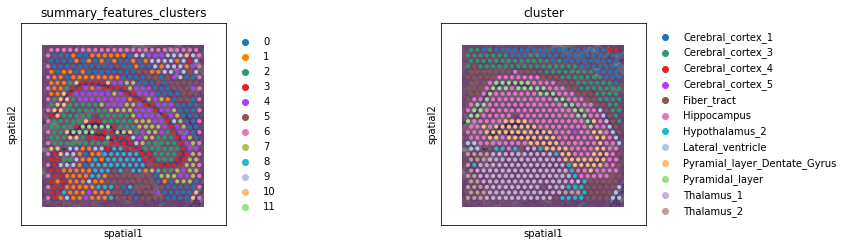

In [164]:
# onlt summary features
adata.obs['summary_features_clusters'] = cluster_features(
    [adata.obsm[f] for f in feature_names if ('summary' in f) ]) #and ('size4' not in f)])
sc.pl.spatial(adata, color=['summary_features_clusters', 'cluster'])



In [153]:
adata.obsm['summary_size1_scale1.0']

summary_quantile_0.9_ch_0  summary_quantile_0.5_ch_0  \
AAAGACCCAAGTCGCG-1                      140.0                      112.0   
AAAGGGATGTAGCAAG-1                      144.0                      114.0   
AAAGTCACTGATGTAA-1                      139.0                      115.0   
AAATGGCATGTCTTGT-1                      138.0                      109.0   
AAATGGTCAATGTGCC-1                      146.0                      113.0   
...                                       ...                        ...   
TTGTAATCCGTACTCG-1                      144.0                      107.0   
TTGTATCACACAGAAT-1                      137.0                      114.0   
TTGTCGTTCAGTTACC-1                      143.0                      114.0   
TTGTGGCCCTGACAGT-1                      144.0                      114.0   
TTGTTCAGTGTGCTAC-1                      141.0                      115.0   

                    summary_quantile_0.1_ch_0  summary_quantile_0.9_ch_1  \
AAAGACCCAAGTCGCG-1                       78.0                      108.0   
AAAGGGATGTAGCAAG-1                       90.0                      107.0   
AAAGTCACTGATGTAA-1                       84.0                      121.0   
AAATGGCATGTCTTGT-1                       74.0                      101.0   
AAATGGTCAATGTGCC-1                       84.0                      112.0   
...                                       ...                        ...   
TTGTAATCCGTACTCG-1                       68.0                      111.0   
TTGTATCACACAGAAT-1                       81.0                      103.0   
TTGTCGTTCAGTTACC-1                       86.0                      118.0   
TTGTGGCCCTGACAGT-1                       84.0                      113.0   
TTGTTCAGTGTGCTAC-1                       88.0                      114.0   

                    summary_quantile_0.5_ch_1  summary_quantile_0.1_ch_1  \
AAAGACCCAAGTCGCG-1                       80.0                       53.0   
AAAGGGATGTAGCAAG-1                       77.0                       56.0   
AAAGTCACTGATGTAA-1                       94.0                       66.0   
AAATGGCATGTCTTGT-1                       71.0                       45.0   
AAATGGTCAATGTGCC-1                       77.0                       53.0   
...                                       ...                        ...   
TTGTAATCCGTACTCG-1                       74.0                       46.0   
TTGTATCACACAGAAT-1                       78.0                       53.0   
TTGTCGTTCAGTTACC-1                       87.0                       61.0   
TTGTGGCCCTGACAGT-1                       81.0                       55.0   
TTGTTCAGTGTGCTAC-1                       87.0                       62.0   

                    summary_quantile_0.9_ch_2  summary_quantile_0.5_ch_2  \
AAAGACCCAAGTCGCG-1                      140.0                      115.0   
AAAGGGATGTAGCAAG-1                      142.0                      111.0   
AAAGTCACTGATGTAA-1                      141.0                      118.0   
AAATGGCATGTCTTGT-1                      142.0                      111.0   
AAATGGTCAATGTGCC-1                      144.0                      113.0   
...                                       ...                        ...   
TTGTAATCCGTACTCG-1                      146.0                      112.0   
TTGTATCACACAGAAT-1                      139.0                      115.0   
TTGTCGTTCAGTTACC-1                      140.0                      113.0   
TTGTGGCCCTGACAGT-1                      142.0                      113.0   
TTGTTCAGTGTGCTAC-1                      142.0                      115.0   

                    summary_quantile_0.1_ch_2  
AAAGACCCAAGTCGCG-1                       90.0  
AAAGGGATGTAGCAAG-1                       88.0  
AAAGTCACTGATGTAA-1                       93.0  
AAATGGCATGTCTTGT-1                       85.0  
AAATGGTCAATGTGCC-1                       89.0  
...                                       ...  
TTGTAATCCGTACTCG-1              

In [152]:
adata.obsm['histogram_size1_scale1.0']

histogram_ch_0_bin_0  histogram_ch_0_bin_1  \
AAAGACCCAAGTCGCG-1                    13                   185   
AAAGGGATGTAGCAAG-1                     0                     4   
AAAGTCACTGATGTAA-1                    51                   137   
AAATGGCATGTCTTGT-1                    33                   220   
AAATGGTCAATGTGCC-1                     9                   124   
...                                  ...                   ...   
TTGTAATCCGTACTCG-1                    23                   219   
TTGTATCACACAGAAT-1                    18                   171   
TTGTCGTTCAGTTACC-1                    18                    68   
TTGTGGCCCTGACAGT-1                    20                    88   
TTGTTCAGTGTGCTAC-1                    38                   114   

                    histogram_ch_0_bin_2  histogram_ch_0_bin_3  \
AAAGACCCAAGTCGCG-1                   379                   757   
AAAGGGATGTAGCAAG-1                   138                   942   
AAAGTCACTGATGTAA-1                   241                   624   
AAATGGCATGTCTTGT-1                   446                   996   
AAATGGTCAATGTGCC-1                   308                   958   
...                                  ...                   ...   
TTGTAATCCGTACTCG-1                   490                  1006   
TTGTATCACACAGAAT-1                   290                   626   
TTGTCGTTCAGTTACC-1                   394                  1176   
TTGTGGCCCTGACAGT-1                   198                   865   
TTGTTCAGTGTGCTAC-1                   376                  1256   

                    histogram_ch_0_bin_4  histogram_ch_0_bin_5  \
AAAGACCCAAGTCGCG-1                  1630                  2309   
AAAGGGATGTAGCAAG-1                  2617                  2646   
AAAGTCACTGATGTAA-1                  1526                  2634   
AAATGGCATGTCTTGT-1                  1890                  2441   
AAATGGTCAATGTGCC-1                  2101                  2282   
...                                  ...                   ...   
TTGTAATCCGTACTCG-1                  1675                  1765   
TTGTATCACACAGAAT-1                  1336                  2482   
TTGTCGTTCAGTTACC-1                  2244                  2400   
TTGTGGCCCTGACAGT-1                  1908                  2462   
TTGTTCAGTGTGCTAC-1                  2513                  2403   

                    histogram_ch_0_bin_6  histogram_ch_0_bin_7  \
AAAGACCCAAGTCGCG-1                  1701                   780   
AAAGGGATGTAGCAAG-1                  1144                   340   
AAAGTCACTGATGTAA-1                  1915                   642   
AAATGGCATGTCTTGT-1                  1347                   455   
AAATGGTCAATGTGCC-1                  1287                   664   
...                                  ...                   ...   
TTGTAATCCGTACTCG-1                  1503                   853   
TTGTATCACACAGAAT-1                  2057                   778   
TTGTCGTTCAGTTACC-1                  1087                   393   
TTGTGGCCCTGACAGT-1                  1546                   663   
TTGTTCAGTGTGCTAC-1                   979                   190   

                    histogram_ch_0_bin_8  histogram_ch_0_bin_9  ...  \
AAAGACCCAAGTCGCG-1                   125                    42  ...   
AAAGGGATGTAGCAAG-1                    79                    11  ...   
AAAGTCACTGATGTAA-1                   130                    21  ...   
AAATGGCATGTCTTGT-1                    90                     3  ...   
AAATGGTCAATGTGCC-1                   162                    26  ...   
...                                  ...                   ...  ...   
TTGTAATCCGTACTCG-1                   320                    67  ...   
TTGTATCACACAGAAT-1                   148                    15  ...   
TTGTCGTTCAGTTACC-1                   110                    31  ...   
TTGTGGCCCTGACAGT-1                   152                    19  ...   
TTGTTCAGTGTGCTAC-1                    45                     7  ...

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


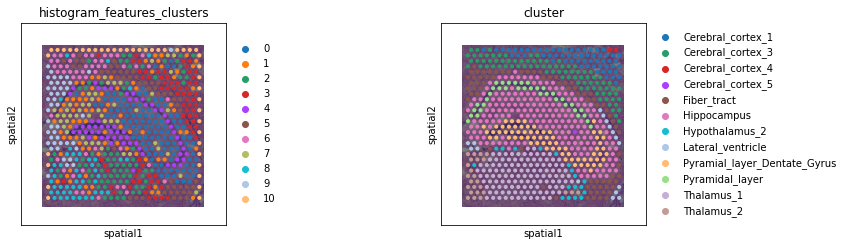

In [165]:
# onlt histogram features
adata.obs['histogram_features_clusters'] = cluster_features(
    [adata.obsm[f] for f in feature_names if ('histogram' in f) ])#and ('size4' not in f)])
sc.pl.spatial(adata, color=['histogram_features_clusters', 'cluster'])




/Users/hannah.spitzer/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


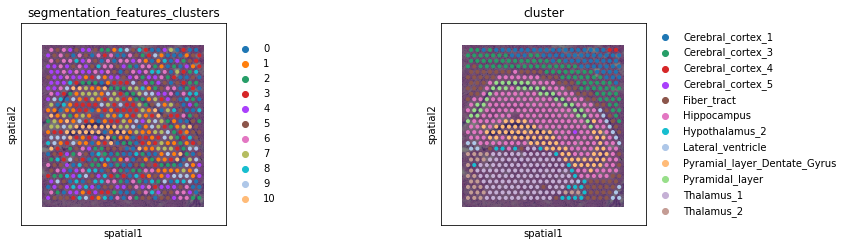

In [168]:
# only segmentation features
adata.obs['segmentation_features_clusters'] = cluster_features(
    [adata.obsm[f] for f in feature_names if 'segmentation' in f and ('size1_scale1.0' in f)])
sc.pl.spatial(adata, color=['segmentation_features_clusters', 'cluster'])




In [116]:
silhouette_score([adata.obsm[f] for f in sorted_f[:30]])

/Users/hannah.spitzer/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


0.18328315

In [107]:
scores['segmentation_size4_scale2.0']

0.4227362

In [122]:
adata.obs['features_clusters'] = cluster_features([adata.obsm[f] for f in sorted_f[:30]])


/Users/hannah.spitzer/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [120]:
adata.obs['features_clusters'] = cluster_features([adata.obsm['segmentation_size1_scale1.0']])



/Users/hannah.spitzer/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


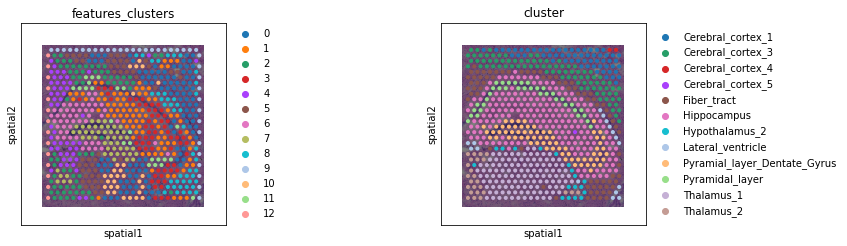

In [123]:
sc.pl.spatial(adata, color=['features_clusters', 'cluster'])

In [117]:
adata.obs

in_tissue  array_row  array_col  n_genes_by_counts  \
AAAGACCCAAGTCGCG-1          1         10         48               6334   
AAAGGGATGTAGCAAG-1          1         24         62               3637   
AAAGTCACTGATGTAA-1          1         10         52               8172   
AAATGGCATGTCTTGT-1          1         13         69               6414   
AAATGGTCAATGTGCC-1          1         33         51               4851   
...                       ...        ...        ...                ...   
TTGTAATCCGTACTCG-1          1         35         55               6659   
TTGTATCACACAGAAT-1          1         12         74               6183   
TTGTCGTTCAGTTACC-1          1         22         58               3620   
TTGTGGCCCTGACAGT-1          1         18         60               3326   
TTGTTCAGTGTGCTAC-1          1         24         64               4087   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAAGACCCAAGTCGCG-1                 8.753845       34447.0           10.447206   
AAAGGGATGTAGCAAG-1                 8.199189       13180.0            9.486531   
AAAGTCACTGATGTAA-1                 9.008591       64908.0           11.080742   
AAATGGCATGTCTTGT-1                 8.766394       34223.0           10.440682   
AAATGGTCAATGTGCC-1                 8.487146       20293.0            9.918080   
...                                     ...           ...                 ...   
TTGTAATCCGTACTCG-1                 8.803875       34310.0           10.443221   
TTGTATCACACAGAAT-1                 8.729721       31862.0           10.369201   
TTGTCGTTCAGTTACC-1                 8.194506       13182.0            9.486684   
TTGTGGCCCTGACAGT-1                 8.109826       11288.0            9.331584   
TTGTTCAGTGTGCTAC-1                 8.315811       15172.0            9.627273   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAAGACCCAAGTCGCG-1                   33.587831                    39.388045   
AAAGGGATGTAGCAAG-1                   43.338392                    48.550835   
AAAGTCACTGATGTAA-1                   29.449374                    35.467123   
AAATGGCATGTCTTGT-1                   32.180113                    37.799141   
AAATGGTCAATGTGCC-1                   37.648450                    43.187306   
...                                        ...                          ...   
TTGTAATCCGTACTCG-1                   29.696881                    35.141358   
TTGTATCACACAGAAT-1                   32.414789                    38.246187   
TTGTCGTTCAGTTACC-1                   43.271127                    48.900015   
TTGTGGCCCTGACAGT-1                   41.265060                    47.377746   
TTGTTCAGTGTGCTAC-1                   38.182178                    44.325073   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
AAAGACCCAAGTCGCG-1                    47.339391                    59.514617   
AAAGGGATGTAGCAAG-1                    55.569044                    66.745068   
AAAGTCACTGATGTAA-1                    43.487706                    56.426018   
AAATGGCATGTCTTGT-1                    45.650586                    58.261988   
AAATGGTCAATGTGCC-1                    50.322771                    61.829202   
...                                         ...                          ...   
TTGTAATCCGTACTCG-1                    42.465753                    55.018945   
TTGTATCACACAGAAT-1                    45.675099                    57.840060   
TTGTCGTTCAGTTACC-1                    56.000607                    66.977697   
TTGTGGCCCTGACAGT-1                    54.961021                    66.530829   
TTGTTCAGTGTGCTAC-1                    51.845505                    63.669918   

                    total_counts_mt  log1p_total_counts_mt  pct_counts_mt  \
AAAGACCCAAGTCGCG-1           5841.0               8.672829      16.956484   
AAAGGGATGTAGCAAG-1           2896.0               7.971431      21.972687   
AAAGTCACTGATGTAA-

In [76]:
import numpy as np

In [78]:
silhouette_scores

{'summary_size1_scale1.0': 0.16961478,
 'summary_size1_scale2.0': 0.14694336,
 'summary_size1_scale4.0': 0.17489979,
 'summary_size2_scale1.0': 0.16128391,
 'summary_size2_scale2.0': 0.18410349,
 'summary_size2_scale4.0': 0.17153738,
 'summary_size4_scale1.0': 0.25315756,
 'summary_size4_scale2.0': 0.24149735,
 'summary_size4_scale4.0': 0.24117696,
 'texture_size1_scale1.0': 0.2035224,
 'texture_size1_scale2.0': 0.19456115,
 'texture_size1_scale4.0': 0.20928498,
 'texture_size2_scale1.0': 0.23215279,
 'texture_size2_scale2.0': 0.24512441,
 'texture_size2_scale4.0': 0.24283807,
 'texture_size4_scale1.0': 0.301265,
 'texture_size4_scale2.0': 0.28925532,
 'texture_size4_scale4.0': 0.2804682,
 'histogram_size1_scale1.0': 0.13372241,
 'histogram_size1_scale2.0': 0.14734977,
 'histogram_size1_scale4.0': 0.15385655,
 'histogram_size2_scale1.0': 0.172541,
 'histogram_size2_scale2.0': 0.16483603,
 'histogram_size2_scale4.0': 0.1457429,
 'histogram_size4_scale1.0': 0.1776836,
 'histogram_size4_s

In [84]:
keys = list(silhouette_scores.keys())

In [81]:
np.argmax(list(silhouette_scores.values()))


34

In [85]:
keys[34]

'segmentation_size4_scale2.0'

In [82]:
sklearn.metrics.silhouette_score?

Signature:
sklearn.metrics.silhouette_score(
    X,
    labels,
    *,
    metric='euclidean',
    sample_size=None,
    random_state=None,
    **kwds,
)
Docstring:
Compute the mean Silhouette Coefficient of all samples.

The Silhouette Coefficient is calculated using the mean intra-cluster
distance (``a``) and the mean nearest-cluster distance (``b``) for each
sample.  The Silhouette Coefficient for a sample is ``(b - a) / max(a,
b)``.  To clarify, ``b`` is the distance between a sample and the nearest
cluster that the sample is not a part of.
Note that Silhouette Coefficient is only defined if number of labels
is 2 <= n_labels <= n_samples - 1.

This function returns the mean Silhouette Coefficient over all samples.
To obtain the values for each sample, use :func:`silhouette_samples`.

The best value is 1 and the worst value is -1. Values near 0 indicate
overlapping clusters. Negative values generally indicate that a sample has
been assigned to the wrong cluster, as a different clust

In [49]:
adata.obsm['summary_size1_scale1.0']

summary_quantile_0.9_ch_0  summary_quantile_0.5_ch_0  \
AAAGACCCAAGTCGCG-1                      140.0                      112.0   
AAAGGGATGTAGCAAG-1                      144.0                      114.0   
AAAGTCACTGATGTAA-1                      139.0                      115.0   
AAATGGCATGTCTTGT-1                      138.0                      109.0   
AAATGGTCAATGTGCC-1                      146.0                      113.0   
...                                       ...                        ...   
TTGTAATCCGTACTCG-1                      144.0                      107.0   
TTGTATCACACAGAAT-1                      137.0                      114.0   
TTGTCGTTCAGTTACC-1                      143.0                      114.0   
TTGTGGCCCTGACAGT-1                      144.0                      114.0   
TTGTTCAGTGTGCTAC-1                      141.0                      115.0   

                    summary_quantile_0.1_ch_0  summary_quantile_0.9_ch_1  \
AAAGACCCAAGTCGCG-1                       78.0                      108.0   
AAAGGGATGTAGCAAG-1                       90.0                      107.0   
AAAGTCACTGATGTAA-1                       84.0                      121.0   
AAATGGCATGTCTTGT-1                       74.0                      101.0   
AAATGGTCAATGTGCC-1                       84.0                      112.0   
...                                       ...                        ...   
TTGTAATCCGTACTCG-1                       68.0                      111.0   
TTGTATCACACAGAAT-1                       81.0                      103.0   
TTGTCGTTCAGTTACC-1                       86.0                      118.0   
TTGTGGCCCTGACAGT-1                       84.0                      113.0   
TTGTTCAGTGTGCTAC-1                       88.0                      114.0   

                    summary_quantile_0.5_ch_1  summary_quantile_0.1_ch_1  \
AAAGACCCAAGTCGCG-1                       80.0                       53.0   
AAAGGGATGTAGCAAG-1                       77.0                       56.0   
AAAGTCACTGATGTAA-1                       94.0                       66.0   
AAATGGCATGTCTTGT-1                       71.0                       45.0   
AAATGGTCAATGTGCC-1                       77.0                       53.0   
...                                       ...                        ...   
TTGTAATCCGTACTCG-1                       74.0                       46.0   
TTGTATCACACAGAAT-1                       78.0                       53.0   
TTGTCGTTCAGTTACC-1                       87.0                       61.0   
TTGTGGCCCTGACAGT-1                       81.0                       55.0   
TTGTTCAGTGTGCTAC-1                       87.0                       62.0   

                    summary_quantile_0.9_ch_2  summary_quantile_0.5_ch_2  \
AAAGACCCAAGTCGCG-1                      140.0                      115.0   
AAAGGGATGTAGCAAG-1                      142.0                      111.0   
AAAGTCACTGATGTAA-1                      141.0                      118.0   
AAATGGCATGTCTTGT-1                      142.0                      111.0   
AAATGGTCAATGTGCC-1                      144.0                      113.0   
...                                       ...                        ...   
TTGTAATCCGTACTCG-1                      146.0                      112.0   
TTGTATCACACAGAAT-1                      139.0                      115.0   
TTGTCGTTCAGTTACC-1                      140.0                      113.0   
TTGTGGCCCTGACAGT-1                      142.0                      113.0   
TTGTTCAGTGTGCTAC-1                      142.0                      115.0   

                    summary_quantile_0.1_ch_2  
AAAGACCCAAGTCGCG-1                       90.0  
AAAGGGATGTAGCAAG-1                       88.0  
AAAGTCACTGATGTAA-1                       93.0  
AAATGGCATGTCTTGT-1                       85.0  
AAATGGTCAATGTGCC-1                       89.0  
...                                       ...  
TTGTAATCCGTACTCG-1              

In [54]:
adata.obs['leiden'] = ada

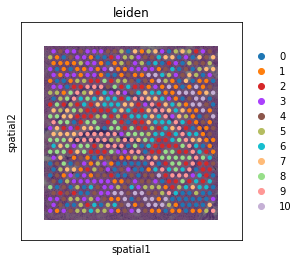

In [55]:
sc.pl.spatial(adata, color='leiden')